<a href="https://colab.research.google.com/github/chi-hun/chi-hun/blob/main/datasetmake(image).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import glob

# tf.data 사용

## 이미지 넘파이 배열(이미 준비된 데이터)

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1)

In [ ]:
img_size = 30
# albumentations 변환 
transformer = A.Compose([A.HorizontalFlip(),
                         A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         A.RandomFog(),
                         A.Rotate(20)
                         ])

def rescsi(image, label=None): # 이미지 리스케일 및 리사이즈
    image = tf.cast(image/255, tf.float32)
    image = tf.image.resize(image, size=(img_size, img_size))
    image = tf.reshape(image, (30,30,3))
    return image, label

def argument(image, label): # 이미지 데이터 증강
    image = transformer(image=image)['image']
    image,label = rescsi(image, label) # 트레인데이터 경우 리스케일링, 리사이즈 동시 진행
    return image, label

def numpy_tf(image, label): # 텐서 넘파이 함수 화
    image, label = tf.numpy_function(func=argument, inp=[image, label], Tout=[tf.float32, tf.uint8])
    image.set_shape((img_size,img_size,3)) #텐서 크기 재지정 (지정 안할시 모델 훈련 오류발생)
    label.set_shape((1,))
    return image, label

def make_dataset(image, label=None, train=False):
    if label is not None  : 
        dataset = tf.data.Dataset.from_tensor_slices((image, label))       
    else : # 라벨이 없을경우(test 데이터)
        dataset = tf.data.Dataset.from_tensor_slices((image))
    
    if train : # train 데이터 경우 데이터 증가, 셔플
        dataset = dataset.map(numpy_tf).shuffle(1024).batch(32)
    else :
        dataset = dataset.map(rescsi).batch(32)

    return dataset

In [ ]:
train_ds = make_dataset(x_train, y_train, True)
validation_ds = make_dataset(x_val, y_val, False)
test_ds = make_dataset(x_test,train=False)

In [ ]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1407/1407 [==============================] - 116s 81ms/step - loss: 1.9412 - accuracy: 0.2566 - val_loss: 1.7416 - val_accuracy: 0.3378
Epoch 2/10
1407/1407 [==============================] - 101s 71ms/step - loss: 1.7679 - accuracy: 0.3325 - val_loss: 1.6649 - val_accuracy: 0.3742
Epoch 3/10
1407/1407 [==============================] - 100s 71ms/step - loss: 1.6886 - accuracy: 0.3735 - val_loss: 1.5688 - val_accuracy: 0.4152
Epoch 4/10
1407/1407 [==============================] - 100s 70ms/step - loss: 1.6214 - accuracy: 0.4013 - val_loss: 1.6155 - val_accuracy: 0.4074
Epoch 5/10
1407/1407 [==============================] - 104s 73ms/step - loss: 1.5763 - accuracy: 0.4230 - val_loss: 1.5239 - val_accuracy: 0.4328
Epoch 6/10
1407/1407 [==============================] - 100s 71ms/step - loss: 1.5435 - accuracy: 0.4399 - val_loss: 1.5188 - val_accuracy: 0.4478
Epoch 7/10
1407/1407 [==============================] - 100s 70ms/step - loss: 1.5133 - accuracy: 0.4514 - val_loss: 1

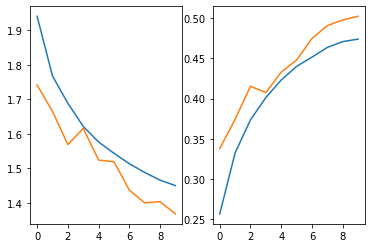

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

## 이미지 파일

In [8]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/공부/archi.zip'

In [233]:
train_folder = '/content/cifar10/train'
test_folder = '/content/cifar10/test'
train_path = sorted(glob.glob(train_folder+'/*/*'))
test_path = sorted(glob.glob(test_folder+'/*/*'))

In [234]:
def label_make(path):
    label = []
    for i in path:
        label.append(i.split('/')[-2])
    return label
train_label = label_make(train_path)
test_label = label_make(test_path)

In [235]:
train_label = pd.get_dummies(train_label)
test_label = pd.get_dummies(test_label)

In [236]:
train_path, validation_path, train_label, validation_label = train_test_split(train_path, train_label, stratify=train_label, test_size=0.1)
len(train_path), len(validation_path), len(train_label), len(validation_label)

(45000, 5000, 45000, 5000)

In [237]:
transformer = A.Compose([A.HorizontalFlip(),
                         A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         A.RandomFog(),
                         A.Rotate(20)
                         ])

img_size = 30

def make_image(path, label=None):
    image = tf.io.decode_png(tf.io.read_file(path))
    return image, label

def rescale_resize(image, label=None):
    image = tf.cast(image/255, tf.float32)
    image = tf.image.resize(image, size=((img_size, img_size)))
    return image, label

def argument(image, label):
    image = transformer(image=image)['image']
    image, label = rescale_resize(image, label)
    return image, label

def num_fuc(image, label):
    image, label = tf.numpy_function(func=argument, inp=[image, label], Tout=[tf.float32, tf.uint8])
    image.set_shape((img_size, img_size, 3))
    label.set_shape((10,))
    return image, label

def make_dataset(path, label=None, train=False):
    if label is not None :
        dataset = tf.data.Dataset.from_tensor_slices((path, label))
        dataset = dataset.map(make_image)
    else :
        dataset = tf.data.Dataset.from_tensor_slices((path))
        dataset = dataset.map(make_image)

    if train:
        dataset = dataset.map(num_fuc).shuffle(1024).batch(32)
    else :
        dataset = dataset.map(rescale_resize).batch(32)

    return dataset

In [238]:
train_ds = make_dataset(train_path, train_label, True)
validation_ds = make_dataset(validation_path, validation_label, False)
test_ds = make_dataset(test_path, train = False)

In [212]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 64)               0   

In [213]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [126]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1140/1140 [==============================] - 91s 78ms/step - loss: 1.9521 - accuracy: 0.2559 - val_loss: 1.7960 - val_accuracy: 0.3314
Epoch 2/10
1140/1140 [==============================] - 87s 76ms/step - loss: 1.7711 - accuracy: 0.3337 - val_loss: 1.9094 - val_accuracy: 0.2837
Epoch 3/10
1140/1140 [==============================] - 86s 75ms/step - loss: 1.6911 - accuracy: 0.3729 - val_loss: 1.5957 - val_accuracy: 0.4277
Epoch 4/10
1140/1140 [==============================] - 87s 76ms/step - loss: 1.6267 - accuracy: 0.4005 - val_loss: 1.5390 - val_accuracy: 0.4467
Epoch 5/10
1140/1140 [==============================] - 86s 74ms/step - loss: 1.5815 - accuracy: 0.4230 - val_loss: 1.5275 - val_accuracy: 0.4474
Epoch 6/10
1140/1140 [==============================] - 86s 75ms/step - loss: 1.5505 - accuracy: 0.4354 - val_loss: 1.4523 - val_accuracy: 0.4664
Epoch 7/10
1140/1140 [==============================] - 86s 75ms/step - loss: 1.5221 - accuracy: 0.4475 - val_loss: 1.4061 -

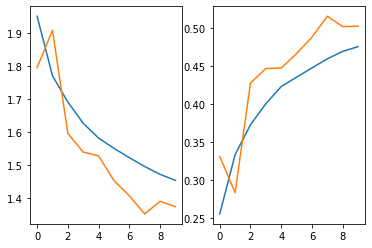

In [127]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

In [230]:
epochs = 20
skf = StratifiedKFold(epochs, shuffle=True)
skf_li = list(skf.split(train_path, train_label))
train_df = pd.DataFrame({'path':train_path, 'label':train_label})

for epoch in range(epochs):
    print(f'{epoch+1}/{epochs}')
    i, j = skf_li[epoch]
    train_path_x = train_df['path'][i].values
    train_label_x = pd.get_dummies(train_df['label'][i].values)
    validation_path_x = train_df['path'][j].values
    validation_label_x = pd.get_dummies(train_df['label'][j].values)
    train_ds = make_dataset(train_path_x, train_label_x, True)
    validation_ds = make_dataset(validation_path_x, validation_label_x, False)
    his = model.fit(train_ds, epochs=1, validation_data=validation_ds)

1/20
 443/1485 [=======>......................] - ETA: 1:16 - loss: 0.4022 - accuracy: 0.8744

KeyboardInterrupt: ignored

In [239]:
for i,j in train_ds.take(50):
    print(j)

tf.Tensor(
[[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]], shape=(32, 10), dtype=uint8)
tf.Tensor(
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 

In [215]:
pre = model.predict(test_ds)

In [216]:
pp = []
for i in pre.argmax(axis=1):
    pp.append(xx[i])


In [197]:
xx = validation_label_x.columns

In [196]:
next(iter(validation_ds))[1][0].numpy().argmax()

0

In [198]:
xx[next(iter(validation_ds))[1][0].numpy().argmax()]

'airplane'

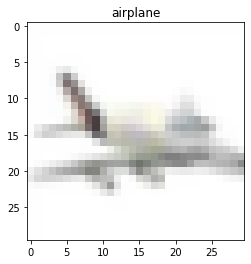

In [200]:
plt.imshow(next(iter(validation_ds))[0][0])
plt.title(xx[next(iter(validation_ds))[1][0].numpy().argmax()])
plt.show()